In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
from scipy.special import rel_entr

In [11]:
# List of available dataset
df18 = pd.read_csv("../exp1-inf/predictions_res18.csv")
df50 = pd.read_csv("../exp1-inf/predictions_res50.csv")
df101 = pd.read_csv("../exp1-inf/predictions_res101.csv")
label = pd.read_csv("../exp1-inf/labels.csv")
prediction = pd.DataFrame({
    "pred18": df18.idxmax(axis=1),
    "pred50": df50.idxmax(axis=1),
    "pred101": df101.idxmax(axis=1),
    "target": label['target']
})
prediction["pred18"] = prediction["pred18"].str.extract('(\d+)').astype(int)
prediction["pred50"] = prediction["pred50"].str.extract('(\d+)').astype(int)
prediction["pred101"] = prediction["pred101"].str.extract('(\d+)').astype(int)

In [12]:
prediction.head()

,pred18,pred50,pred101,target
0,19,19,19,19
1,29,29,29,29
2,0,0,0,0
3,11,11,11,11
4,1,1,1,1


/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


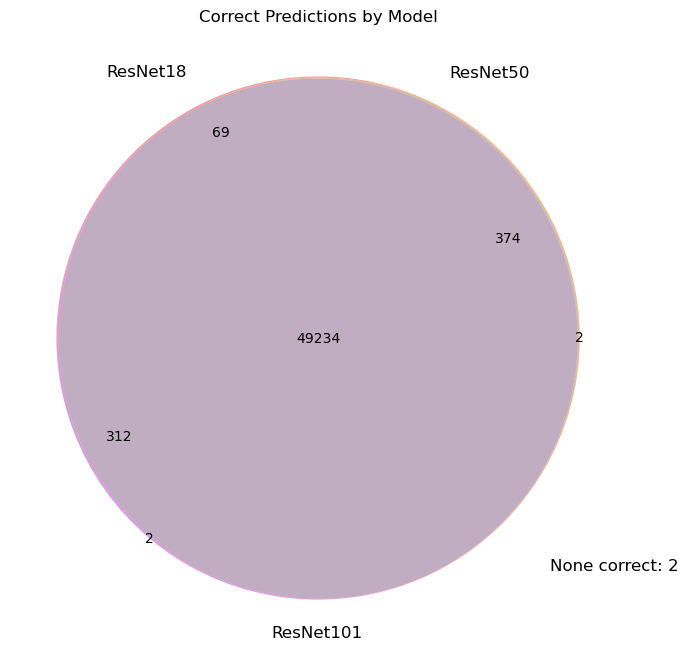

In [13]:
# Accuracy Venn Diagram:
df = prediction
correct_18 = set(df[df['pred18'] == df['target']].index)
correct_50 = set(df[df['pred50'] == df['target']].index)
correct_101 = set(df[df['pred101'] == df['target']].index)
total_indices = set(df.index)
incorrect_all = total_indices - (correct_18 | correct_50 | correct_101)
plt.figure(figsize=(8, 8))
venn_diagram = venn3([correct_18, correct_50, correct_101], ('ResNet18', 'ResNet50', 'ResNet101'))
plt.title('Correct Predictions by Model')
plt.text(0.5, -0.5, f'None correct: {len(incorrect_all)}', fontsize=12)
plt.show()

ou_res18=0.0066042778559456785 | ou_res50=0.019166337153021133 | ou_res101=0.018607261209573407


Text(0, 0.5, 'Density')

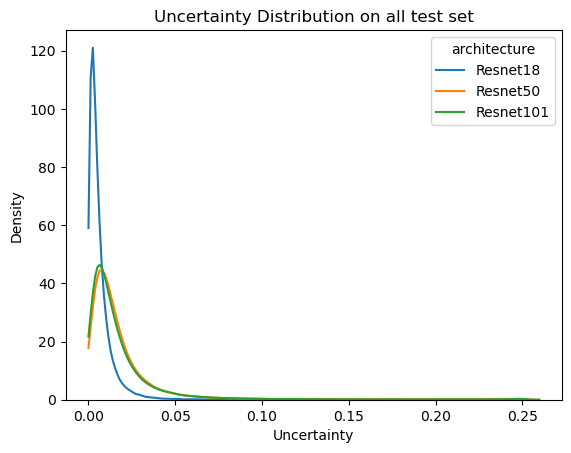

In [15]:
# Uncertainty Visualization
df18["uncertainty"]=1-df18.pow(2).sum(axis=1) # Brier Score
df50["uncertainty"]=1-df50.pow(2).sum(axis=1)
df101["uncertainty"]=1-df101.pow(2).sum(axis=1)
ou_res18 = df18["uncertainty"].mean()
ou_res50 = df50["uncertainty"].mean()
ou_res101 = df101["uncertainty"].mean()
print(f"{ou_res18=} | {ou_res50=} | {ou_res101=}")
sns.kdeplot(df18['uncertainty'], clip=[0, 1], label='Resnet18')
sns.kdeplot(df50['uncertainty'], clip=[0, 1], label='Resnet50')
sns.kdeplot(df101['uncertainty'], clip=[0, 1], label='Resnet101')
plt.legend(title='architecture')
plt.title('Uncertainty Distribution on all test set')
plt.xlabel('Uncertainty')
plt.ylabel('Density')

oc_res18=0.9965206616599999 | oc_res50=0.9843708269687799 | oc_res101=0.9858173066698801


Text(0, 0.5, 'Density')

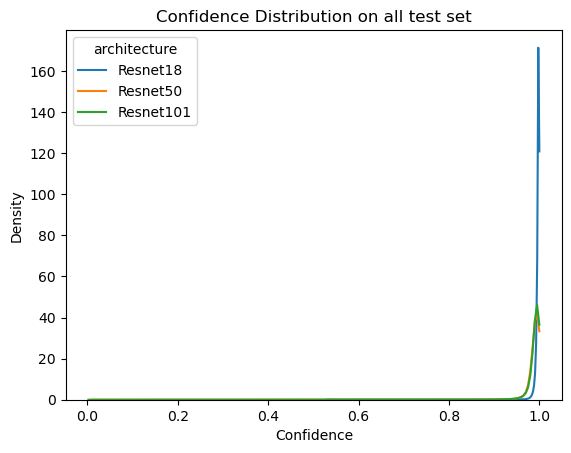

In [16]:
df18["confidence"]=df18.max(axis=1) # prediction confidence
df50["confidence"]=df50.max(axis=1)
df101["confidence"]=df101.max(axis=1)
oc_res18 = df18["confidence"].mean()
oc_res50 = df50["confidence"].mean()
oc_res101 = df101["confidence"].mean()
print(f"{oc_res18=} | {oc_res50=} | {oc_res101=}")
sns.kdeplot(df18['confidence'], clip=[0, 1], label='Resnet18')
sns.kdeplot(df50['confidence'], clip=[0, 1], label='Resnet50')
sns.kdeplot(df101['confidence'], clip=[0, 1], label='Resnet101')
plt.title('Confidence Distribution on all test set')
plt.legend(title='architecture')
plt.xlabel('Confidence')
plt.ylabel('Density')

,pred18,pred50,pred101,target,cor18,cor50,cor101,kl_18_50,kl_18_101,kl_50_18,kl_50_101,kl_101_18,kl_101_50
0,19,19,19,19,1,1,1,0.003660,0.001558,0.008423,0.007455,0.001299,0.002855
1,29,29,29,29,1,1,1,0.001544,0.006185,0.007489,0.004638,0.031698,0.010562


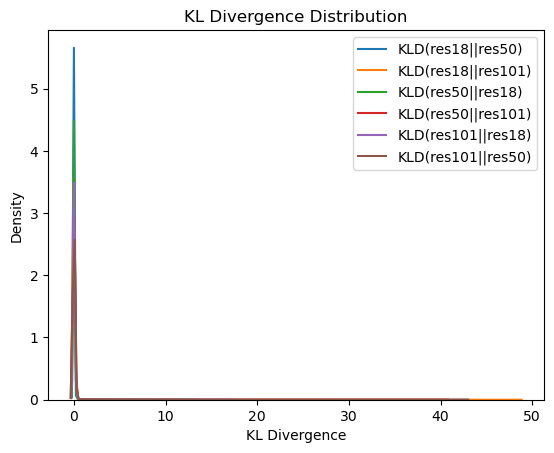

In [24]:
df["cor18"] = np.where(df["pred18"]==df["target"],1,0)
df["cor50"] = np.where(df["pred50"]==df["target"],1,0)
df["cor101"] = np.where(df["pred101"]==df["target"],1,0)
def calc_kl(Q,P,numclass):
    return rel_entr(Q.iloc[:,0:numclass],P.iloc[:,0:numclass]).sum(1)
df["kl_18_50"] = calc_kl(df18,df50,100)
df["kl_18_101"] = calc_kl(df18,df101,100)
df["kl_50_18"] = calc_kl(df50,df18,100)
df["kl_50_101"] = calc_kl(df50,df101,100)
df["kl_101_18"] = calc_kl(df101,df18,100)
df["kl_101_50"] = calc_kl(df101,df50,100)
display(df.head(2))
sns.kdeplot(df["kl_18_50"], label='KLD(res18||res50)')
sns.kdeplot(df["kl_18_101"], label='KLD(res18||res101)')
sns.kdeplot(df["kl_50_18"], label='KLD(res50||res18)')
sns.kdeplot(df["kl_50_101"], label='KLD(res50||res101)')
sns.kdeplot(df["kl_101_18"], label='KLD(res101||res18)')
sns.kdeplot(df["kl_101_50"], label='KLD(res101||res50)')
plt.title('KL Divergence Distribution')
plt.xlabel('KL Divergence')
plt.ylabel('Density')
plt.legend()

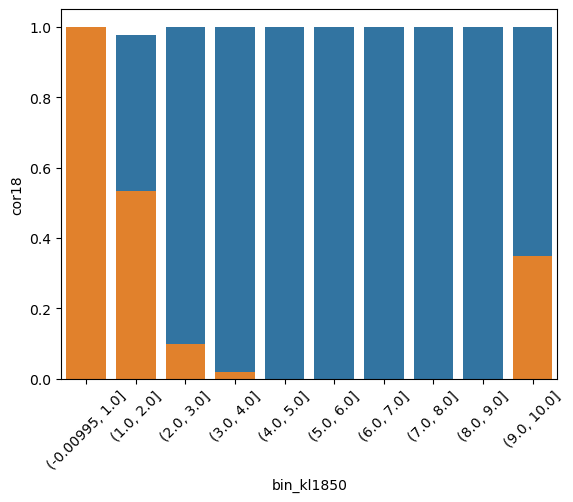

In [58]:
binnum=10
df['bin_kl1850'] = pd.cut(df['kl_18_50'].clip(0,10), bins=binnum)
grouped_kl1850 = df.groupby('bin_kl1850')[['cor18','cor50']].mean().reset_index()
sns.barplot(x='bin_kl1850', y='cor18', data=grouped_kl1850)
sns.barplot(x='bin_kl1850', y='cor50', data=grouped_kl1850)
plt.xticks(rotation=45)
plt.show()